# CanEat
**fresh and rotten classification**

This project will explores the development of an automated fresh and rotten classification system using Machine Learning.

## Setup and Download The Dataset

In [ ]:
!kaggle datasets download -d 'swoyam2609/fresh-and-stale-classification'

Dataset URL: https://www.kaggle.com/datasets/swoyam2609/fresh-and-stale-classification
License(s): Community Data License Agreement - Permissive - Version 1.0
100% 2.84G/2.84G [01:33<00:00, 41.1MB/s]
100% 2.84G/2.84G [01:33<00:00, 32.7MB/s]


In [ ]:
import zipfile

In [ ]:
dataset_zip = zipfile.ZipFile('fresh-and-stale-classification.zip', 'r')

dataset_zip.extractall()

dataset_zip.close()

## Import Packages

In [ ]:
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
print(tf. __version__)

2.15.0


## Prepare The Dataset

In [ ]:
# Define the directories
train_dir = '/content/dataset/Train'
validation_dir = '/content/dataset/Test'

# Define function to load data
def load_data(PATH):
    filenames, fruit, fresh = [], [], []
    for file in tqdm(os.listdir(PATH)):
        for img in os.listdir(os.path.join(PATH, file)):
            fresh.append(0 if file[0] == 'f' else 1)
            fruit.append(file[5:] if file[0] == 'f' else file[6:])
            filenames.append(os.path.join(PATH, file, img))
    df = pd.DataFrame({
        'filename': filenames,
        'fruit': fruit,
        'fresh': fresh
    })
    return df

# Load training and validation data
df_train = load_data(train_dir).sample(frac=1)
df_test = load_data(validation_dir).sample(frac=1)

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23619 entries, 15063 to 14097
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  23619 non-null  object
 1   fruit     23619 non-null  object
 2   fresh     23619 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 738.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 6738 entries, 1288 to 6534
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6738 non-null   object
 1   fruit     6738 non-null   object
 2   fresh     6738 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 210.6+ KB


In [ ]:
import shutil

# Define the mapping of incorrect classes name
rename_mapping = {
    'freshpatato': 'freshpotato',
    'freshtamto': 'freshtomato',
    'rottenpatato': 'rottenpotato',
    'rottentamto': 'rottentomato'
}

# Rename the directories
for incorrect_name, correct_name in rename_mapping.items():
    incorrect_path = os.path.join(validation_dir, incorrect_name)
    correct_path = os.path.join(validation_dir, correct_name)
    if os.path.exists(incorrect_path):
        shutil.move(incorrect_path, correct_path)

# Verify the corrected directories
print("Corrected Validation set classes:", os.listdir(validation_dir))

Corrected Validation set classes: ['freshtomato', 'freshapples', 'freshbanana', 'rottenokra', 'freshoranges', 'freshokra', 'rottenbanana', 'rottenpotato', 'rottenapples', 'rottenoranges', 'freshcucumber', 'freshpotato', 'rottentomato', 'rottencucumber']


In [ ]:
# Filter out unnecessary classes
unnecessary_classes = ['bittergroud', 'capsicum']
for cls in unnecessary_classes:
    shutil.rmtree(os.path.join(train_dir, 'fresh' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(train_dir, 'rotten' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(validation_dir, 'fresh' + cls), ignore_errors=True)
    shutil.rmtree(os.path.join(validation_dir, 'rotten' + cls), ignore_errors=True)

# Verify the classes
print("Training set classes:", os.listdir(train_dir))
print("Validation set classes:", os.listdir(validation_dir))

Training set classes: ['freshtomato', 'freshapples', 'freshbanana', 'rottenokra', 'freshoranges', 'freshokra', 'rottenbanana', 'rottenpotato', 'rottenapples', 'rottenoranges', 'freshcucumber', 'freshpotato', 'rottentomato', 'rottencucumber']
Validation set classes: ['freshtomato', 'freshapples', 'freshbanana', 'rottenokra', 'freshoranges', 'freshokra', 'rottenbanana', 'rottenpotato', 'rottenapples', 'rottenoranges', 'freshcucumber', 'freshpotato', 'rottentomato', 'rottencucumber']


## Data Preprocessing

In [ ]:
train_generator = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest').flow_from_directory(
                                         directory=train_dir,
                                         batch_size=50,
                                         class_mode='categorical',
                                         target_size=(224, 224))

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    directory=validation_dir,
    batch_size=20,
    class_mode='categorical',
    target_size=(224, 224))

# Verify the classes in the generators
print("Training set classes:", train_generator.class_indices)
print("Validation set classes:", validation_generator.class_indices)

# Generate a batch of data
x_batch, y_batch = train_generator.next()

# Print the shape and first few labels
print("Labels shape:", y_batch.shape)
print("First few labels:", y_batch[:5])

Found 21044 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.
Training set classes: {'freshapples': 0, 'freshbanana': 1, 'freshcucumber': 2, 'freshokra': 3, 'freshoranges': 4, 'freshpotato': 5, 'freshtomato': 6, 'rottenapples': 7, 'rottenbanana': 8, 'rottencucumber': 9, 'rottenokra': 10, 'rottenoranges': 11, 'rottenpotato': 12, 'rottentomato': 13}
Validation set classes: {'freshapples': 0, 'freshbanana': 1, 'freshcucumber': 2, 'freshokra': 3, 'freshoranges': 4, 'freshpotato': 5, 'freshtomato': 6, 'rottenapples': 7, 'rottenbanana': 8, 'rottencucumber': 9, 'rottenokra': 10, 'rottenoranges': 11, 'rottenpotato': 12, 'rottentomato': 13}
Labels shape: (50, 14)
First few labels: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## Build and Train The Model

In [ ]:
def mobilenetv2_model(num_classes, input_shape=(224, 224, 3), learning_rate=0.0001):

    # Load the pre-trained MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)  # num_classes

    # Define the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
model = mobilenetv2_model(num_classes=14)
model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
# early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# class myCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('accuracy')>0.999):
#       print("\nReached 99.9% accuracy so cancelling training!")
#       self.model.stop_training = True

# callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
)

Epoch 1/30
420/420 [==============================] - 367s 846ms/step - loss: 0.9661 - accuracy: 0.7028 - val_loss: 0.3602 - val_accuracy: 0.8775
Epoch 2/30
420/420 [==============================] - 342s 813ms/step - loss: 0.3750 - accuracy: 0.8732 - val_loss: 0.2373 - val_accuracy: 0.9190
Epoch 3/30
420/420 [==============================] - 341s 811ms/step - loss: 0.2830 - accuracy: 0.9047 - val_loss: 0.1927 - val_accuracy: 0.9348
Epoch 4/30
420/420 [==============================] - 342s 814ms/step - loss: 0.2394 - accuracy: 0.9198 - val_loss: 0.1671 - val_accuracy: 0.9438
Epoch 5/30
420/420 [==============================] - 339s 807ms/step - loss: 0.2137 - accuracy: 0.9260 - val_loss: 0.1489 - val_accuracy: 0.9513
Epoch 6/30
420/420 [==============================] - 341s 813ms/step - loss: 0.1827 - accuracy: 0.9370 - val_loss: 0.1354 - val_accuracy: 0.9555
Epoch 7/30
420/420 [==============================] - 352s 836ms/step - loss: 0.1718 - accuracy: 0.9407 - val_loss: 0.1183 -

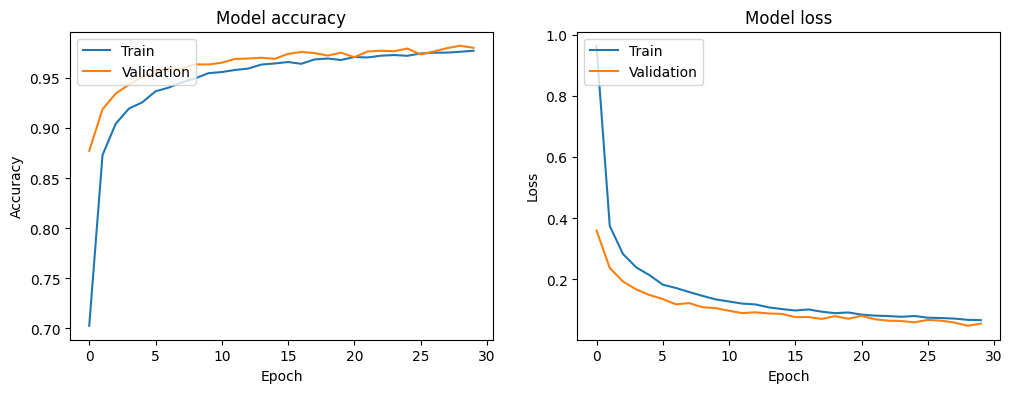

In [ ]:
# Plot the training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Evaluate The Model

In [ ]:
loss, accuracy = model.evaluate(validation_generator, steps=validation_generator.samples // validation_generator.batch_size)
accuracy_percentage = accuracy * 100

print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy_percentage:.2f}%')

336/336 [==============================] - 32s 95ms/step - loss: 0.0554 - accuracy: 0.9804
Validation Loss: 0.05537811294198036
Validation Accuracy: 98.04%


## Save and Convert The Model

In [ ]:
# Save the model
model.save('my_model.h5')
print("Model saved to 'my_model.h5'")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to 'my_model.h5'


## Model Prediction

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image

def predict_uploaded_image(model):
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Load the image
        img = image.load_img(fn, target_size=(224, 224))
        # Convert the image to an array and Scale the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        # Make predictions
        classes = model.predict(x, batch_size=10)
        # Get the class indices
        class_indices = train_generator.class_indices
        # Get the predicted class label
        predicted_class = list(class_indices.keys())[np.argmax(classes)]
        print("File:", fn)
        print("Predicted Class:", predicted_class)
        print("Probabilities:", classes)

# Use the function to predict an uploaded image
predict_uploaded_image(model)

Saving apel busuk.jpg to apel busuk.jpg
1/1 [==============================] - 2s 2s/step
File: apel busuk.jpg
Predicted Class: rottenapples
Probabilities: [[4.0432562e-07 6.5237799e-08 1.2869947e-08 2.0304350e-08 8.5798142e-08
  8.1737577e-09 1.3442849e-08 9.9999833e-01 1.4751521e-07 5.8757599e-09
  1.8307807e-07 1.0207832e-09 5.7503371e-07 1.0363473e-07]]
